<h1>Testing the idea for frag clustering</h1>
<p>The idea is to use a two stage process to try and cluster all of the remaining peaks based on unknown fragments</p>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import adduct_cluster as ac

In [3]:
a_c = ac.AdductCluster(mass_tol = 5, mh_biggest = True)
a_c.init_from_file('/Users/simon/git/metabolomics_tools/discretisation/java_src/James/txt/std1_Beth20512.peakml.txt')
# a_c.init_from_file('test_small.txt')

[M+ACN+H, M+ACN+H [C13], [M-CO]+ACN+H, [M-CO]+ACN+H [C13], [M-H2O]+ACN+H, [M-H2O]+ACN+H [C13], [M-CH2O2]+ACN+H, [M-CH2O2]+ACN+H [C13], [M-CO2]+ACN+H, [M-CO2]+ACN+H [C13], M+NH4, M+NH4 [C13], [M-CO]+NH4, [M-CO]+NH4 [C13], [M-H2O]+NH4, [M-H2O]+NH4 [C13], [M-CH2O2]+NH4, [M-CH2O2]+NH4 [C13], [M-CO2]+NH4, [M-CO2]+NH4 [C13], M+Na, M+Na [C13], [M-CO]+Na, [M-CO]+Na [C13], [M-H2O]+Na, [M-H2O]+Na [C13], [M-CH2O2]+Na, [M-CH2O2]+Na [C13], [M-CO2]+Na, [M-CO2]+Na [C13], M+K, M+K [C13], [M-CO]+K, [M-CO]+K [C13], [M-H2O]+K, [M-H2O]+K [C13], [M-CH2O2]+K, [M-CH2O2]+K [C13], [M-CO2]+K, [M-CO2]+K [C13], M+2H, M+2H [C13], [M-CO]+2H, [M-CO]+2H [C13], [M-H2O]+2H, [M-H2O]+2H [C13], [M-CH2O2]+2H, [M-CH2O2]+2H [C13], [M-CO2]+2H, [M-CO2]+2H [C13], M+H, M+H [C13], [M-CO]+H, [M-CO]+H [C13], [M-H2O]+H, [M-H2O]+H [C13], [M-CH2O2]+H, [M-CH2O2]+H [C13], [M-CO2]+H, [M-CO2]+H [C13]]
Loaded 3078 peaks from /Users/simon/git/metabolomics_tools/discretisation/java_src/James/txt/std1_Beth20512.peakml.txt
Created 3078 cluster

In [4]:
a_c.reset_counts()
a_c.multi_sample(1000)
a_c.compute_posterior_probs()


<p>Run VB</p>

In [565]:
# a_c.init_vb()
# for i in range(100):
#     a_c.vb_step()


# for peak in a_c.todo:
#     print "Peak: {}".format(peak.mass)
#     for poss in a_c.possible[peak]:
#         print "\t {} {}".format(poss.transformation.name,poss.prob)

<p>assign all peaks to their most likely cluster</p>

In [5]:
a_c.map_assign()

Find some big clusters

31 big clusters found
Biggest has 9 members
CLUSTER 171
Peak: 160.971917385,16.9395008087 -> M+H [C13],158.961286096 (p=0.457)
Peak: 131.973928539,14.1772003174 -> [M-CO]+H,158.961566709 (p=0.863)
Peak: 200.995179495,18.321100235 -> M+ACN+H,158.961353942 (p=0.589)
Peak: 142.961525522,15.5586996078 -> [M-H2O]+H [C13],158.961458919 (p=0.701)
Peak: 159.968892946,15.5586996078 -> M+H,158.961616494 (p=1.0)
Peak: 113.963437378,16.9395008087 -> [M-CH2O2]+H,158.961640235 (p=1.0)
Peak: 141.958381022,12.7937002182 -> [M-H2O]+H,158.961669256 (p=1.0)
Peak: 183.988060772,14.1772003174 -> [M-H2O]+ACN+H [C13],158.961445067 (p=0.781)
Peak: 154.9898365,14.1772003174 -> [M-CH2O2]+ACN+H,158.961490255 (p=0.781)
M+H/M+H [C13] = 42.7915135815
[M-H2O]+H/[M-H2O]+H [C13] = 52.0544023352
CLUSTER 400
Peak: 183.025314877,18.321100235 -> [M-CO2]+ACN+H [C13],183.97796373 (p=0.977)
Peak: 140.99531259,15.5586996078 -> [M-CO2]+H,183.977865382 (p=1.0)
Peak: 185.988498445,19.7012996674 -> M+H [C13],183.977867155 (p=1.0)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


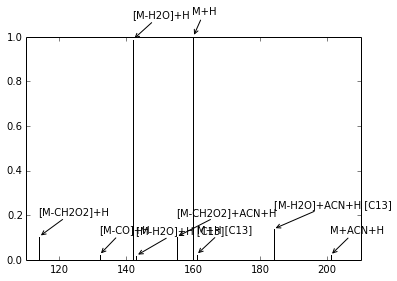

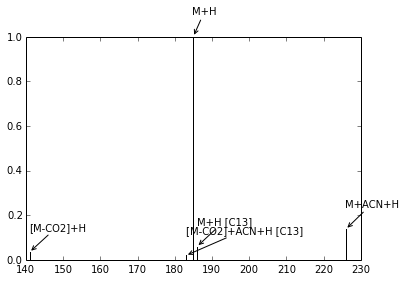

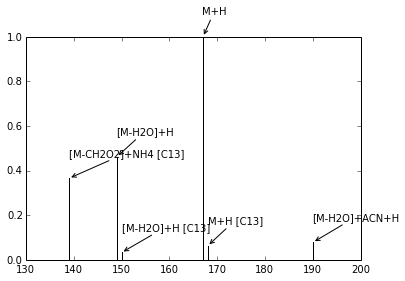

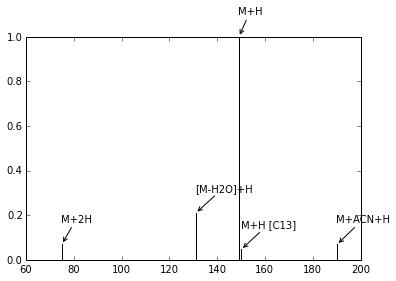

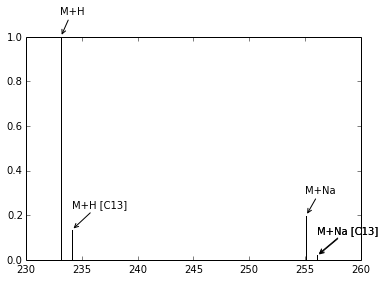

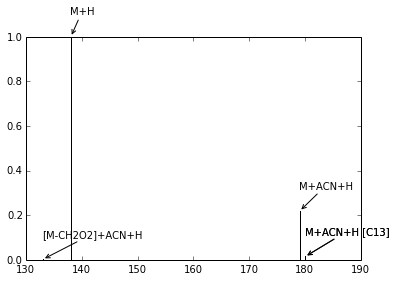

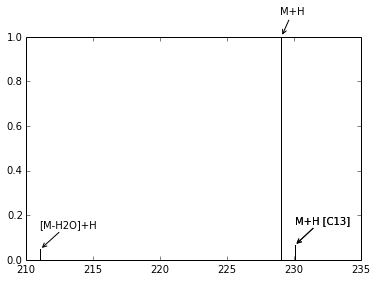

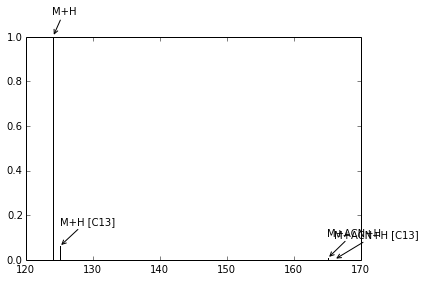

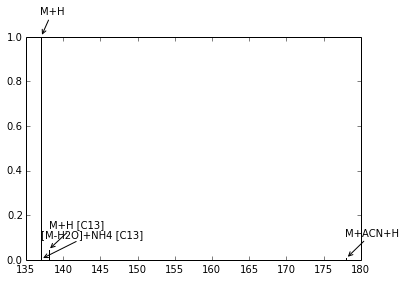

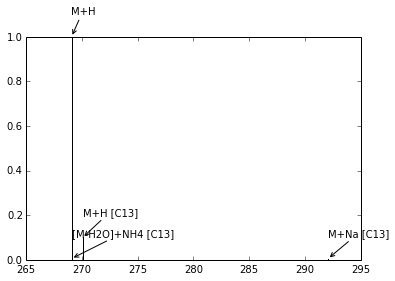

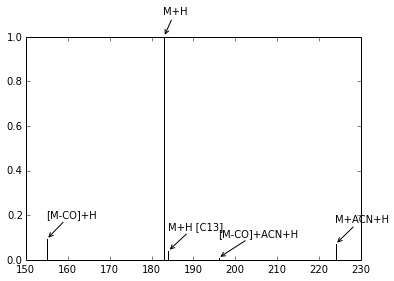

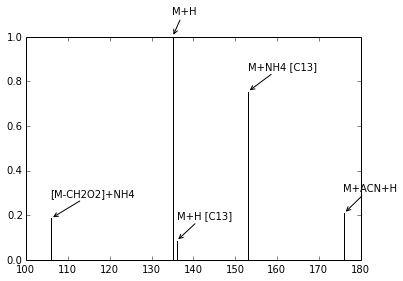

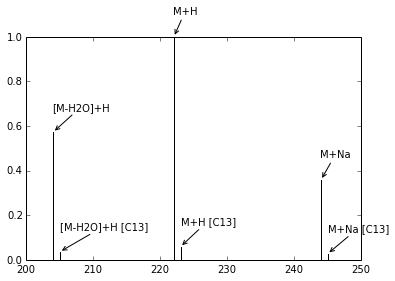

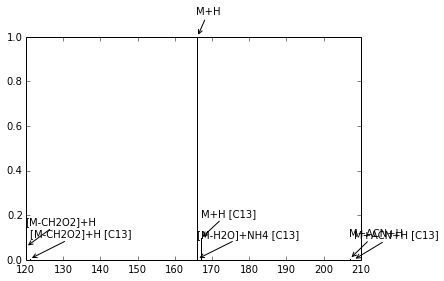

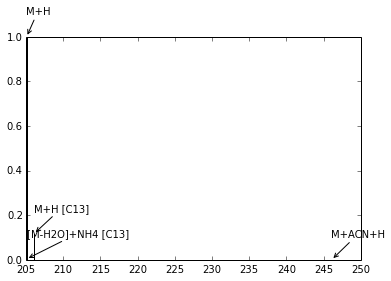

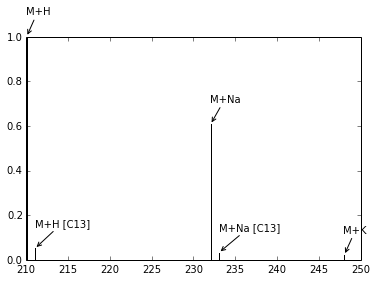

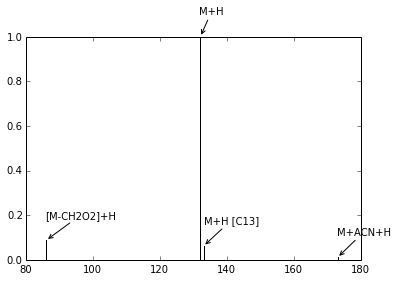

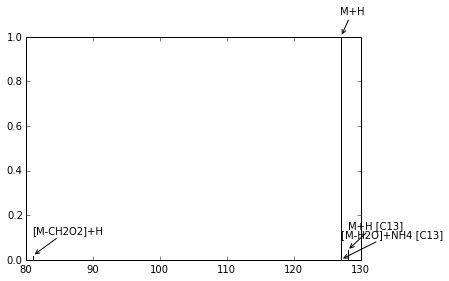

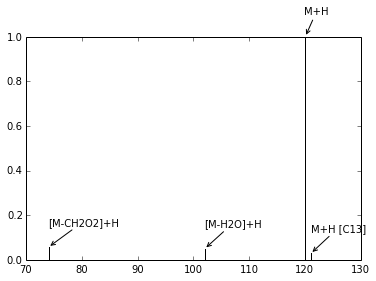

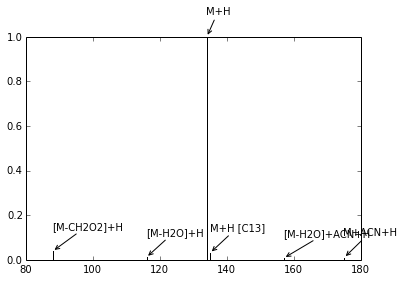

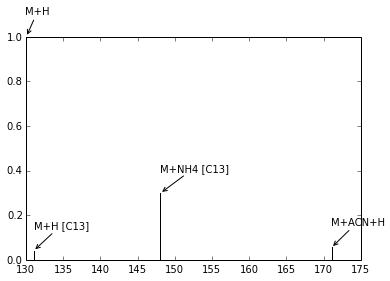

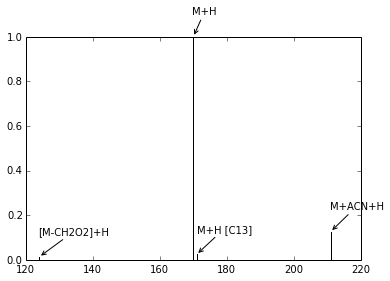

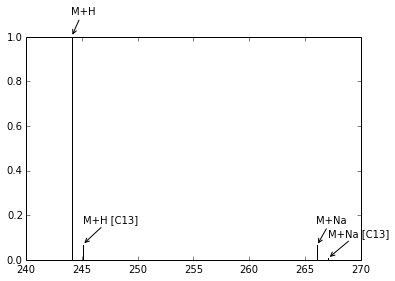

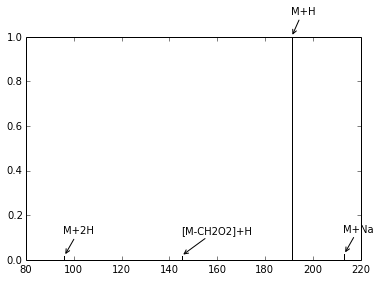

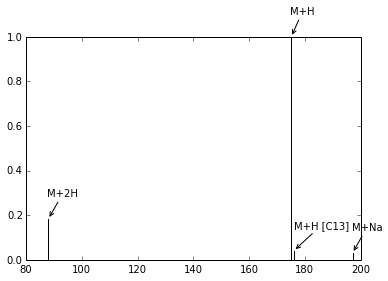

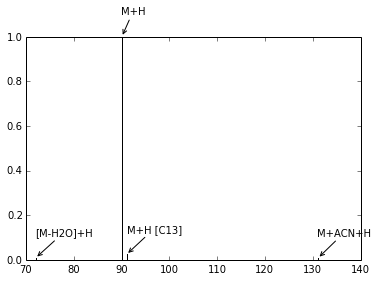

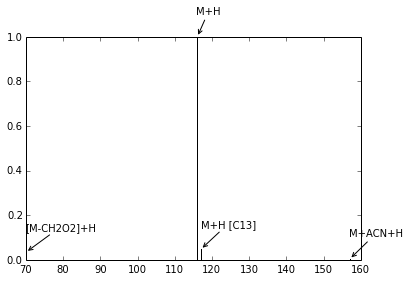

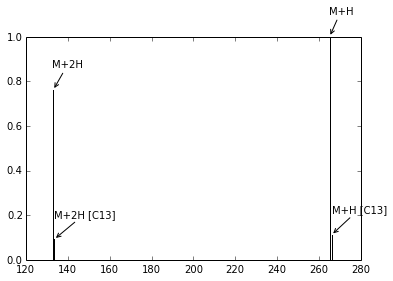

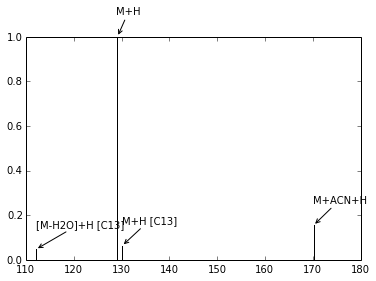

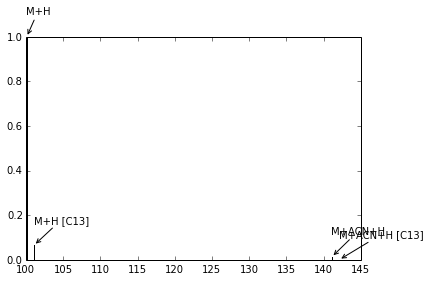

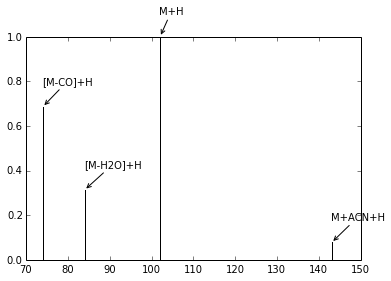

In [6]:
threshold = 4
big_clusters = []
biggest = a_c.clusters[0]
for cluster in a_c.clusters:
    if cluster.N >= threshold:
        big_clusters.append(cluster)
        if cluster.N >= biggest.N:
            biggest = cluster

print "{} big clusters found".format(len(big_clusters))
print "Biggest has {} members".format(biggest.N)


for c in big_clusters:
    a_c.cluster_plot(c)

# a_c.cluster_plot(biggest)


In [6]:
singletons = []
for peak in a_c.peaks:
    if a_c.Z[peak].cluster.N == 1:
        singletons.append(peak)
print len(singletons)

2428


Match against a database

In [8]:
import numpy as np
db_file = 'database/std1_mols.csv'
n_hits = 0
false_negs = 0
proton_mass = 1.00727645199076
c_mass = np.array([c.M for c in a_c.clusters if c.N>0])
p_mass = np.array([p.mass - proton_mass for p in a_c.peaks])
with open(db_file,'r') as f:
    for line in f:
        s_line = line.split(',')
        mass = float(s_line[3])
        delta_mass = mass*5*1e-6
        mass_start,mass_end = (mass - delta_mass,mass+delta_mass)
        hits = np.where((c_mass > mass_start)*(c_mass < mass_end))[0]
        
        prior_hits = np.where((p_mass > mass_start)*(p_mass < mass_end))[0]
        if len(hits)>0:
            n_hits += 1
            print "Molecule: {} ({}) FOUND".format(s_line[1],mass)
        elif len(prior_hits)>0:
            print "Molecule: {} ({}) FOUND IN PRIOR".format(s_line[1],mass)
            false_negs += 1
        else:
            print "Molecule: {} ({})".format(s_line[1],mass)
       
        

print "{} hits, {} false negs".format(n_hits,false_negs)

Molecule:  Spermidine (145.157897626) FOUND
Molecule:  Glycerol (92.0473441234) FOUND
Molecule:  Cholesterol (386.354866101)
Molecule:  1-Butanol (74.0731649435)
Molecule:  Oxaloacetate (132.005873239)
Molecule:  Imidazole (68.037448139)
Molecule:  glyceraldehyde (90.0316940591)
Molecule:  Inosine (268.080769517) FOUND
Molecule:  L-Phenylalanine (165.078978603) FOUND
Molecule:  L-Leucine (131.094628667) FOUND
Molecule:  L-Tryptophan (204.08987764) FOUND
Molecule:  2-Phenylglycine (151.063328539) FOUND
Molecule:  Selenomethionine (196.995500403) FOUND
Molecule:  L-Methionine (149.051049293) FOUND
Molecule:  Guanine (151.049409809) FOUND
Molecule:  Pyridoxine (169.073893225) FOUND
Molecule:  Imidazole-4-acetate (126.042927448) FOUND
Molecule:  L-Valine (117.078978603) FOUND
Molecule:  Adenine (135.054495187) FOUND
Molecule:  L-Proline (115.063328539) FOUND
Molecule:  Serotonin (176.094963018) FOUND
Molecule:  Taurine (125.014663787) FOUND
Molecule:  trans-4-Hydroxy-L-proline (131.0582431

[('M+H', 1.0)]
CLUSTER 1740
Peak: 104.05253325,819.455993652 -> [M-CH2O2]+H,149.050736107 (p=0.842)
Peak: 151.061338415,818.064025879 -> M+H [C13],149.050707125 (p=0.999)
Peak: 150.05816394,820.854003906 -> M+H,149.050887488 (p=1.0)
M+H/M+H [C13] = 28.6335462413


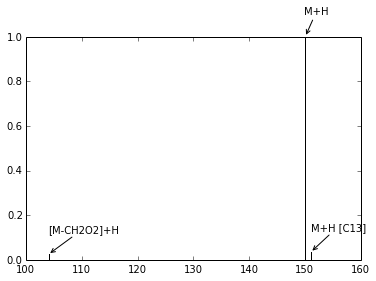

In [9]:
print [(p.transformation.name,p.prob) for p in a_c.possible[a_c.peaks[1740]]]
cl = a_c.Z[a_c.peaks[1740]].cluster
a_c.cluster_plot(cl)

<p>Loop over all singletons and find their mass difference with M+H in the clusters within `a_c.rt_tol`</p>

In [10]:
import numpy as np
mass_differences = []
for peak in singletons:
    for cluster in a_c.clusters:
        if cluster.N > 0:
            if peak is cluster.mHPeak:
                continue
            elif np.abs(peak.rt - cluster.mHPeak.rt) < a_c.rt_tol:
                mass_differences.append(cluster.mHPeak.mass - peak.mass)

In [11]:
mass_differences = np.array(mass_differences)
mass_differences.sort()

In [12]:
histogram = {}
start_pos = 0
finished = False
threshold = 7
biggest = []
while not finished:
    new_key = str(mass_differences[start_pos])
    histogram[new_key] = 1
    search_pos = start_pos + 1
    search_finished = False
    while not search_finished:
        if search_pos >= len(mass_differences):
            search_finished = True
            finished = True
            break
        if np.abs((mass_differences[start_pos] - mass_differences[search_pos]) / mass_differences[start_pos])*1e6 < 2*a_c.mass_tol:
            histogram[new_key] += 1
            if histogram[new_key] > biggest:
                biggest = histogram[new_key]
            search_pos += 1
        else:
            if histogram[new_key] >= threshold:
                biggest.append(new_key)
            search_finished = True
            start_pos = search_pos


In [16]:
import sys
sys.path.append('/Users/simon/git/MS2LDA')
from efcompute import ef_assigner as ef

In [17]:
e = ef.ef_assigner(verbose = False)

Atoms being considered = ['C', 'H', 'N', 'O', 'P', 'S']


In [19]:
for m in biggest:
    a = e.find_formulas([np.abs(float(m))],ppm = 20)
    print "{}: {} -> {}".format(m,histogram[m],a[1][0])

-135.975075134: 7 -> C3H5O2PS
-102.031721349: 10 -> C4H6O3
-72.9676095483: 8 -> None
-67.9875127792: 7 -> None
-64.9787826901: 7 -> None
-64.4776156492: 7 -> None
-61.9705080943: 8 -> None
-44.4656454236: 10 -> None
-43.9639996446: 7 -> None
-42.0105832701: 7 -> C2H2O
-41.0267088804: 13 -> C2H3N
-28.5019468753: 9 -> None
-28.0313306706: 9 -> C2H4
-23.0160769694: 14 -> None
-20.5135116693: 9 -> None
-20.5133057924: 33 -> None
-20.0117451317: 11 -> None
-17.5048454554: 9 -> None
-15.9776337864: 7 -> None
-14.0156186389: 8 -> CH2
-10.9971604691: 7 -> None
-8.49033301657: 10 -> None
-7.98623981951: 7 -> None
7.98613732831: 7 -> None
7.98879958082: 7 -> None
8.49020522892: 9 -> None
10.9970681576: 7 -> None
15.977547626: 7 -> None
17.5047790194: 9 -> None
20.0116115364: 11 -> None
20.513012233: 24 -> None
20.5132350409: 18 -> None
23.0158520504: 12 -> None
28.0310528053: 7 -> C2H4
28.4879733239: 7 -> None
28.5019291659: 9 -> None
41.0261458706: 10 -> C2H3N
44.4654384975: 11 -> None
61.97037

In [224]:
PROTON_MASS = 1.00727645199076
ATOM_NAME_LIST = ['C', 'H', 'N', 'O', 
                  'P', 'S', 'C13', 'F', 
                  'Cl']

ATOM_MASS_LIST = [12.00000000000,   1.00782503214,    14.00307400524,   15.99491462210, 
                  30.97376151200,   31.97207069000,   13.00335483780,   18.99840325000, 
                  34.96885271000]
ATOM_VALENCE_LIST = [4, 1, 3, 2, 3, 2, 4, 1, 1]

ATOM_MASSES = dict(zip(ATOM_NAME_LIST, ATOM_MASS_LIST))

In [225]:
ACN = {'C':2,'H':3,'N':1}
acn_mass = 0.0
for atom in ACN:
    acn_mass += ACN[atom]*ATOM_MASSES[atom]
print acn_mass, acn_mass + PROTON_MASS

41.0265491017 42.0338255537


Make a histogram of the transformations

In [24]:
trans_counts = {}
for p in a_c.Z:
    if a_c.Z[p].transformation in trans_counts:
        trans_counts[a_c.Z[p].transformation] += 1
    else:
        trans_counts[a_c.Z[p].transformation] = 1
        

In [27]:
trans,counts = trans_counts.keys(),trans_counts.values()

In [30]:
import pylab as plt

(0, 100)

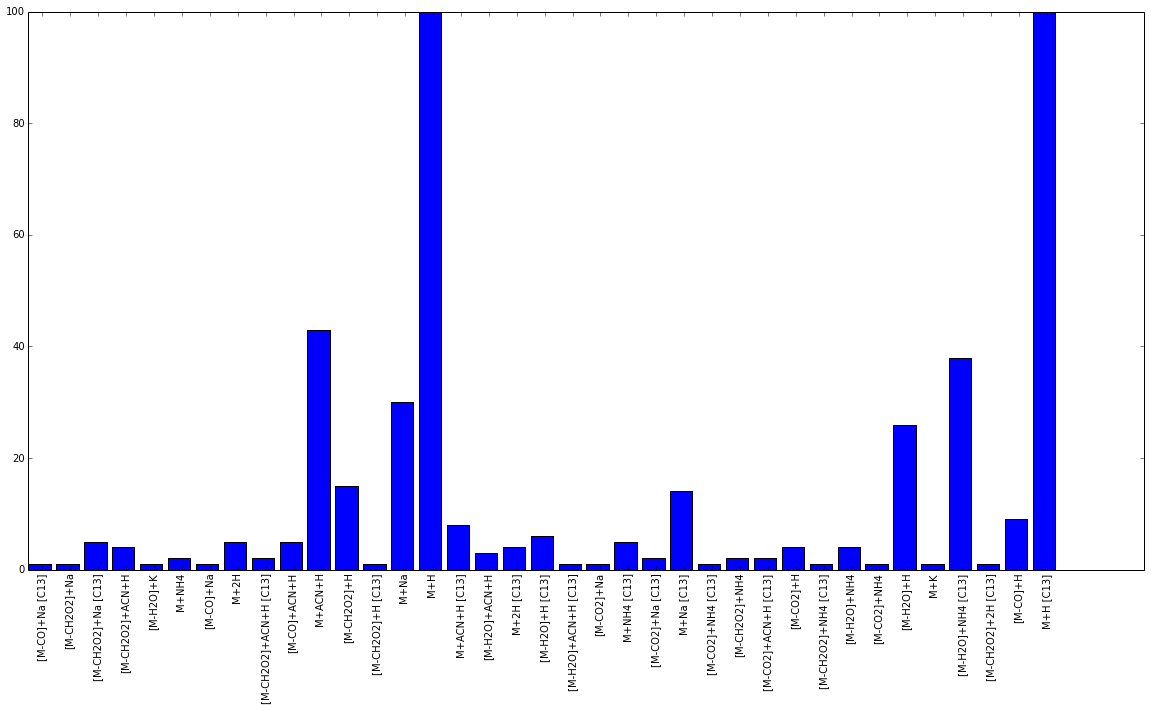

In [50]:
plt.figure(figsize=(20,10))
plt.bar(range(len(counts)),counts)
plt.xticks([i+0.5 for i in range(len(counts))],trans)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylim([0,100])

All transformations

In [153]:
trans = []
rt_tol = 10
for p in a_c.peaks:
    M = p.mass - proton_mass
    rt = p.rt
    for q in a_c.peaks:
        if abs(rt - q.rt) < rt_tol:
            trans.append(q.mass - M)
            trans.append(2*q.mass - M)

In [154]:
trans = np.array(trans)

In [155]:
trans = np.sort(trans)

In [156]:
val = [trans[0]]
count = [1]
for i in range(1,len(trans)):
    if abs((trans[i]-val[-1])/trans[i])*1e6 < 10:
        val[-1] = trans[i]
#         val[-1] = (val[-1]*count[-1] + trans[i])/(1.0*count[-1] + 1)
        count[-1] += 1
    else:
        val.append(trans[i])
        count.append(1)
        
    
print len(val)


122424


(0, 100)

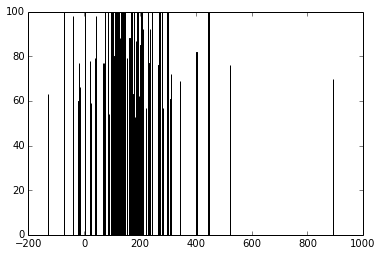

In [157]:
val = np.array(val)
count = np.array(count)
pos = np.where(count>50)[0]
plt.bar(val[pos],count[pos])
plt.ylim([0,100])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':


<Container object of 1 artists>

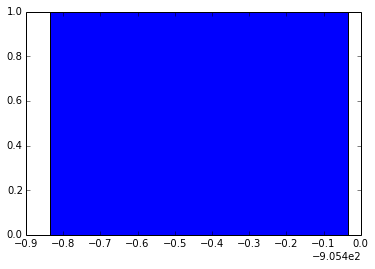

In [76]:
plt.bar(val[pos],count[pos])

In [158]:
for p in pos:
    print "{}: {}".format(val[p],count[p])

-130.983410942: 63
-72.0024152908: 80
-71.9843334786: 89
-71.9572098652: 150
-40.018800178: 98
-20.974260774: 60
-19.5055132631: 77
-17.0028274913: 66
1.0073020331: 3134
2.01080745791: 193
19.01811883: 66
21.5207881213: 78
22.9895483843: 59
38.0629393148: 79
42.034494074: 98
42.0419924501: 51
67.0554948186: 77
67.0704947877: 63
70.0111763587: 77
73.9708824505: 51
73.9980497843: 175
74.0160267145: 117
74.0316795428: 87
74.0429231342: 71
74.0560860067: 67
74.0667759089: 55
74.0904565204: 67
84.0213680174: 84
84.0425243342: 100
84.056220852: 88
84.0648567644: 60
84.0734377404: 59
84.0883819576: 87
84.1064504696: 58
85.0581364762: 121
85.0742642146: 104
87.0368895316: 54
95.064927585: 197
95.0883029787: 107
95.5530908169: 54
96.0493485221: 96
98.0239062081: 59
100.015604532: 64
100.908434581: 75
100.944012294: 138
100.977959408: 63
101.050065508: 365
101.085995066: 183
101.115576472: 173
101.158564222: 241
102.99393474: 73
103.115292346: 872
103.147318134: 124
103.171867035: 73
104.0425261

In [88]:
1.0072764519*2

2.0145529038

In [123]:
print 2*(e2.atom_masses['C13'] - e2.atom_masses['C'])

2.0067096756


In [125]:
e2 = ef.ef_assigner(enforce_ppm = True)

Atoms being considered = ['C', 'H', 'N', 'O', 'P', 'S']


In [161]:
# e2.find_formulas([18.0107747736],ppm=20,polarisation="None")
# e2.find_formulas([41.0267595061],ppm=20,polarisation="None")
# e2.find_formulas([46.0056306894],ppm=20,polarisation="None")
# e2.find_formulas([73.0008759241],ppm=20,polarisation="None")
e2.find_formulas([101.050065508],ppm=20,polarisation="Pos")
# e2.find_formulas([189.249431045],ppm=20,polarisation="None")

Searching for neutral mass 100.042789 (1/1) at tolerance 20 ppm
- found 3 candidate(s), best formula = C5H10P


({100.04278905600924: [{'C': 5, 'H': 10, 'N': 0, 'O': 0, 'P': 1, 'S': 0}]},
 ['C5H10P'],
 [100.04278905600924])

In [148]:
print val.shape

(93033,)


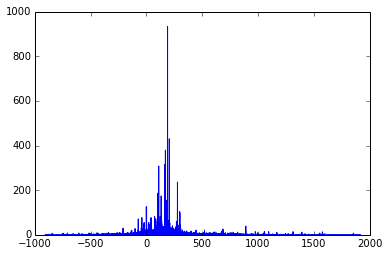

In [151]:
plt.plot(val,count)